# It's Raining Cats and Dogs!
   
##  Lab Assignment Eight: The Storm Continues
   
### Justin Ledford, Luke Wood, Traian Pop

## Business Understanding

### Overview
   
The data set we are analyzing has over 25000 evenly distributed pictures of dogs and cats. We found it on https://www.kaggle.com/c/dogs-vs-cats and decided it would be a good set to practice processing and analyzing image data due to the clear classification metric of dogs|cats and the large number of high quality photos.
 
### Purpose 
   
This data was originally collected for the purpose of a competition hosted by Kaggle to see who could create the most accurate algorithm that could distinguish between pictures of dogs and cats. Petfined.com are the original owners of the data, and they donated over 3 million pictures of sheltered animals that have been hand classified by them. Because of this, we are highly confident in the data, as the vast majority of humans can successfully identify between a dog and a cat. 
   
The competition itself is long over, but the page still remains for people to play and experiment with the data. This data is important due to potential it holds to help develop and train algorithms that could be used to evolve image recognition software. We can progressively check how useful the data we get from the set is by comparing it against our own classification and seeing if our own conclusions (i.e. if an image classifies a cat or not) match with the information we collect from it. 

### Predictions
   
We are not expecting perfect results as cats and dogs can look fairly similar at times, and the black and white color format of the pictures already limits easily differential characteristics between the two animals, such as fur color. However, we do believe that due to the large number and quality of the pictures, we can definitely expect to get a large amount of successful results when processing and analyzing the data.

### Applications
This dataset could be used to train an image classifier that could be used by hotels or apartment that only allow one type of pet.  For example, Luke's apartment complex only allows cats to stay in the homes so the complex could theoretically place cameras in the hallway and test to see which type of pets are being brought in.  This would allow them to more efficiently enforce the no dogs rule which is frequently broken.  

Another application is it could also be used for cataloging by a pet shelter to allow owners to search for cats or dogs similar to one they are looking for.

A third application would be to track the history of animals by taking pictures of them at each shelter and documenting information about the animal at each stage.

## Data Preparation
   
In this section, we pre-process the data in order to be usable by our techniques. The first method represents how we take all the images in a given folder (after they have been modified by our own scripts) and append them together to be analyzed later.
   
In pre-processing the data, we used three separate scripts:
   
<B>1) aspect</B>: Script developed by Fred Weinhaus (http://www.fmwconcepts.com/imagemagick/aspect/index.php) in order to resize an image to a specific size using imagmagick (https://www.imagemagick.org/) allowing either cropping or padding to deal with the aspect ratio change. (Not shown due to length)
   
<B>2) process.sh</B>: Script that shrinks images to 150 x 150 while simultaneously using aspect to ensure accuracy. Uses padding to fill space leftover. Leaves all original content there, but adds noise to the edges to fill blanks.
   
<B>3) crop_process.sh</B>: Script that shrinks images to 150 x 150 while simultaneously using aspect to ensure accuracy. Instead of padding, it simply crops the image in respective to the middle of the original image. Loses quality and detail but no additional noise is added.
   
Afterward we preprocess the images with aspect and one of the following scripts, we append them all together in one dataframe.

In [6]:
import numpy as np
from PIL import Image
import pandas as pd
import os
import glob
import plotly
import matplotlib.pyplot as plt
%matplotlib inline 

#ignore warnings
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)

def warn(*args, **kwargs):
    pass
warnings.warn = warn

w,h = 150,150

def wildcard_to_df(fpath, greyscale=True):
    X = []
    y = []
    
    for img_file in glob.iglob(fpath):
        # Read in img as greyscale
        with Image.open(img_file).convert("L") as img:

            # Keep y for each image in separate array
            if 'cat' in img_file:
                y.append(0)
            else:
                y.append(1)

            # Concatenate RGB into one row and collect
            X.append(np.concatenate(np.array(img)))

    X = np.array(X)
    y = np.array(y)

    #convert to DF
    return pd.DataFrame(data=X, index=y), X, y

In [7]:
#convert to dataframe
df, X, y = wildcard_to_df('data/*.jpg')

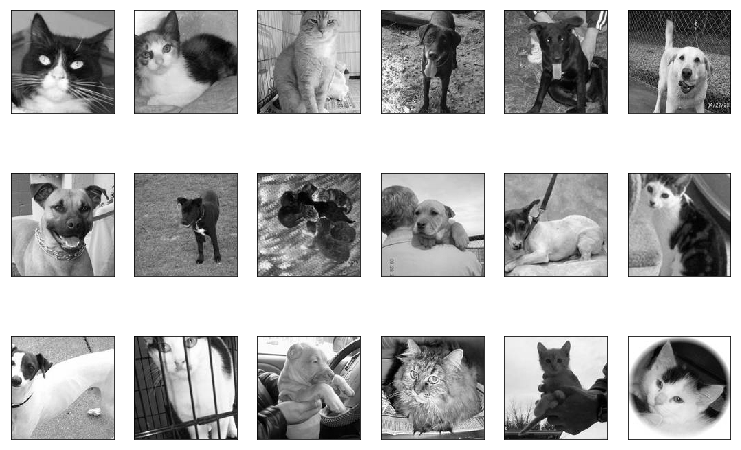

In [8]:
# a helper plotting function (modified code from Professor Eric Larson's repository)
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(X, h, w) # defaults to showing a 3 by 6 subset of the faces
# Visualize some images
plt.show()

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [17]:
from sklearn.model_selection import train_test_split

NUM_CLASSES = 2
X = X.astype(np.float32)
y = y.astype(np.int32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

X_train.shape

(1600, 22500)

In [18]:
%%time

# make a CNN with conv layer and max pooling
cnn = Sequential()
cnn.add(Reshape((1,150,150), input_shape=(1,22500)))
cnn.add(Conv2D(filters=16, kernel_size= (2, 2), padding='same', input_shape=(1,150,150)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
# add one layer on flattened output
cnn.add(Flatten())
cnn.add(Dense(NUM_CLASSES))
cnn.add(Activation('softmax'))

# Let's train the model 
cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

CPU times: user 8min 34s, sys: 41.7 s, total: 9min 16s
Wall time: 3min 1s


In [25]:
import sklearn.metrics as mt

yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
cm = mt.confusion_matrix(y_test,yhat_cnn)
print(cm)

[[  0 187]
 [  0 213]]
